# package

In [1]:
using Distributions
using Random
using LinearAlgebra
using Plots
using StatsBase
using LaTeXStrings
using ProgressBars
using ProgressMeter
using DataFrames
using CSV
using Base.Threads
using StatsPlots
using Latexify
gr()

Plots.GRBackend()

In [2]:
Threads.nthreads()

16

In [3]:
path = "/Users/nishimurarei/home/lab/data/cubic_data/int/001_1/"

"/Users/nishimurarei/home/lab/data/cubic_data/int/001_1/"

# フォワードモデル

In [4]:
function ini()
    # Hund's Rule Ground J-Multiplet Ce3+ n4f=1
    n4f = 1
    L = 3
    S = 1 / 2
    J = L - S
    g = 1 + (J * (J + 1) + S * (S + 1) - L * (L + 1)) / (2 * J * (J + 1))
    Jz = [5 / 2, 3 / 2, 1 / 2, -1 / 2, -3 / 2, -5 / 2]
    return J, g, Jz
end
J, g, Jz = ini()

(2.5, 0.8571428571428572, [2.5, 1.5, 0.5, -0.5, -1.5, -2.5])

In [5]:
#B20_true = 4
B40_true = 0.1167
#B44_true = 3

0.1167

In [6]:
function Onn_make(B40)
    # O20は不要
    #=
    # O20
    O20_vec = (3 * Jz.^2 .- J*(J+1)) * B20
    O20 = diagm(0 => O20_vec)
    =#
    
    B44 = 5 * B40
    
    # O40
    O40_vec = (35 * Jz.^4 - 30 * J * (J + 1) * Jz.^2 + 25 * Jz.^2 .- 6 * J * (J + 1) .+ 3 * J^2 * (J + 1)^2) * B40
    O40 = diagm(0 => O40_vec)
    
    # O44
    O44 = zeros(6, 6)

    Jz_vec_1 = Jz[1] .- collect(0:3)
    O44[5,1] = sqrt(prod(J .+ Jz_vec_1) * prod((J + 1) .- Jz_vec_1)) * B44 / 2

    Jz_vec_2 = Jz[2] .- collect(0:3)
    O44[6,2] = sqrt(prod(J .+ Jz_vec_2) * prod((J + 1) .- Jz_vec_2)) * B44 / 2

    Jz_vec_5 = Jz[5] .+ collect(0:3)
    O44[1,5] = sqrt(prod(J .- Jz_vec_5) * prod((J + 1) .+ Jz_vec_5)) * B44 / 2

    Jz_vec_6 = Jz[6] .+ collect(0:3)
    O44[2,6] = sqrt(prod(J .- Jz_vec_6) * prod((J + 1) .+ Jz_vec_6)) * B44 / 2

    Onn = O40 + O44

    return Onn
end

Onn_make (generic function with 1 method)

In [7]:
# check
Onn_make(B40_true)

6×6 Matrix{Float64}:
  7.002     0.0      0.0     0.0     15.6569   0.0
  0.0     -21.006    0.0     0.0      0.0     15.6569
  0.0       0.0     14.004   0.0      0.0      0.0
  0.0       0.0      0.0    14.004    0.0      0.0
 15.6569    0.0      0.0     0.0    -21.006    0.0
  0.0      15.6569   0.0     0.0      0.0      7.002

In [8]:
function para()
    Temp_table_chi= collect(0.2:0.2:70) # length 350
    n_chi = length(Temp_table_chi)
    
    #Temp_table_spc = collect(0.5:0.1:50) # length 496
    Temp_table_spc = collect(0.2:0.2:70) # length 350
    n_spc = length(Temp_table_spc)
    
    return Temp_table_chi, Temp_table_spc, n_chi, n_spc
end

Temp_table_chi, Temp_table_spc, n_chi, n_spc = para()

([0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0  …  68.2, 68.4, 68.6, 68.8, 69.0, 69.2, 69.4, 69.6, 69.8, 70.0], [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0  …  68.2, 68.4, 68.6, 68.8, 69.0, 69.2, 69.4, 69.6, 69.8, 70.0], 350, 350)

In [9]:
# 磁化率
function chi(Onn)
    magfield = 0.01
    magdir = [0,0,1]
    nor_magdir = magdir / sqrt(sum(magdir.^2))
    
    # 対角要素
    Hmag_vec_0 = Jz * nor_magdir[3] * magfield * g * 0.67171
    Hmag = diagm(0 => Hmag_vec_0)
    
    # 非対角要素はmagdir[x,y]が0なので0
    
    # 結晶場＋磁場ハミルトニアンの行列要素
    H = Onn + Hmag

    eigval, eigvec = eigen(H)

    chi_inv_Temp = zeros(n_chi)
    for (i, Temp) in enumerate(Temp_table_chi)
        eigval_2 = - eigval / Temp
        eigval_2_max = maximum(eigval_2)
        eigval_ratio = eigval_2 .- eigval_2_max
        exp_eigval = exp.(eigval_ratio)
        sumexp = sum(exp_eigval)

        mag_z = zeros(6)
        for i in 1:6
            eigvec_check = eigvec[:,i]
            mag_z[i] = eigvec_check' * (eigvec_check .* Jz) * exp_eigval[i] / sumexp
        end

        Jmag_z = sum(mag_z) * g * (-1)
        Jmag = Jmag_z

        chi = Jmag / magfield * 0.5585
        chi_inv = 1 / chi
        chi_inv_Temp[i] = chi_inv
    end
    return chi_inv_Temp
end

chi (generic function with 1 method)

In [10]:
# 比熱
function spc(Onn)
    magfield = 5
    magdir = [1,1,0]
    nor_magdir = magdir / sqrt(sum(magdir.^2))
    # 対角要素 0

    # 非対角要素
    Hmag_vec_1 = sqrt.((J .+ Jz) .* (J .- Jz .+ 1)) * (nor_magdir[1]+nor_magdir[2]*im)*magfield*g*0.67171/2
    Hmag_vec_1 = Hmag_vec_1[1:5]
    Hmag_1 = diagm(1 => Hmag_vec_1)
    
    Hmag_vec_2 = conj.(Hmag_vec_1)
    Hmag_2 = diagm(-1 => Hmag_vec_2)
    
    Hmag = Hmag_1 + Hmag_2

    #結晶場＋磁場ハミルトニアンの行列要素
    H = Onn + Hmag

    eigval, eigvec = eigen(H)

    SpcHeat_Temp = zeros(n_spc)
    for (i, Temp) in enumerate(Temp_table_spc)
        eigval_2 = - eigval / Temp
        eigval_2_max = maximum(eigval_2)
        eigval_ratio = eigval_2 .- eigval_2_max
        exp_eigval = exp.(eigval_ratio)

        Z0 = sum(exp_eigval)
        Z1 = sum(eigval_2 .* exp_eigval)
        Z2 = sum(eigval_2.^2 .* exp_eigval)
        
        SpcHeat=(- (Z1/Z0)^2 + (Z2/Z0) )*8.31441
        SpcHeat_Temp[i] = SpcHeat
    end
    return SpcHeat_Temp
end

spc (generic function with 1 method)

# データ読み込み

In [11]:
#gaussian noise std
noise_chi = 0.01
noise_spc = 1

1

In [12]:
b_chi = (1 / noise_chi)^2
b_spc = (1 / noise_spc)^2

1.0

In [13]:
#データ数
n_int = n_chi + n_spc

700

In [14]:
#ノイズ強度
b_int = b_chi + b_spc

10001.0

In [15]:
noise_int = sqrt(1/b_int)

0.009999500037496875

## chi data

In [20]:
d_chi = Normal(0,noise_chi)
chi_inv_Temp = chi(Onn_make(B40_true))
chi_inv_Temp_noise = chi_inv_Temp + rand(d_chi,n_chi)

350-element Vector{Float64}:
  1.0061161259327005
  1.9588311463694348
  2.892506283689034
  3.7206960558027924
  4.537348713897621
  5.289564424294284
  6.011692573271415
  6.73504666621464
  7.369020372922122
  7.994415091174451
  8.621103663122936
  9.20282186466782
  9.737195290028582
  ⋮
 85.83315142913126
 86.06499758563652
 86.32655085081521
 86.55417466780845
 86.8109282772843
 87.04105662750405
 87.27331363817886
 87.52984750525334
 87.79566111052425
 88.03465954942787
 88.26995295198027
 88.51258039354511

## spc data

In [18]:
spc_data = CSV.read("/Users/nishimurarei/home/lab/data/cubic_data/spc/1/spc_data.csv", DataFrame)

,true_data,noise_data
,Float64,Float64
1,2.04595e-7,-0.0776041
2,0.00778169,-1.99684
3,0.1845,0.118214
4,0.754923,0.669311
5,1.57476,1.98245
6,2.37425,2.1539
7,2.99412,0.728367
8,3.39404,3.62253
9,3.59803,2.05838


In [19]:
SpcHeat_Temp = spc_data.true_data
SpcHeat_Temp_noise = spc_data.noise_data;

In [331]:
function making_data()
    
    d_chi = Normal(0,noise_chi)
    chi_inv_Temp = chi(Onn_make(B40_true))
    chi_inv_Temp_noise = chi_inv_Temp + rand(d_chi,n_chi)
    
    d_spc = Normal(0,noise_spc)
    SpcHeat_Temp = spc(Onn_make(B40_true))
    SpcHeat_Temp_noise = SpcHeat_Temp + rand(d_spc,n_spc)
    
    return chi_inv_Temp, chi_inv_Temp_noise, SpcHeat_Temp, SpcHeat_Temp_noise
end

making_data (generic function with 1 method)

In [21]:
#chi_inv_Temp, chi_inv_Temp_noise, SpcHeat_Temp, SpcHeat_Temp_noise = making_data();

# データ可視化

In [24]:
path = "/Users/nishimurarei/home/lab/data/cubic_data/int/001_1/"

"/Users/nishimurarei/home/lab/data/cubic_data/int/001_1/"

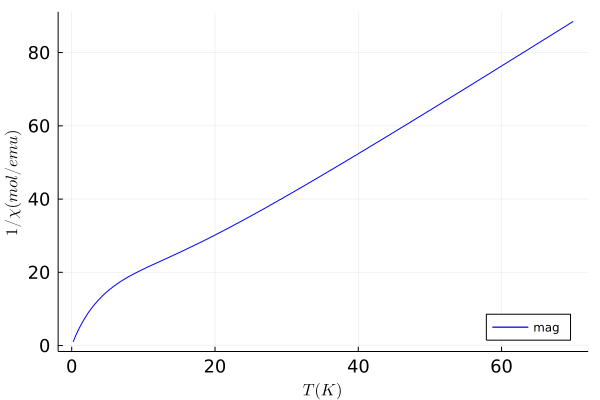

In [25]:
#chi

plot(Temp_table_chi, chi_inv_Temp_noise,label="mag",color="blue")
plot!(xlabel=L"T(K)",ylabel=L"1/\chi(mol/emu)")
plot!(legendfontsize=10,xtickfont=font(12), ytickfont=font(12))
plot!(legend=:bottomright)

In [26]:
savefig(path * "data_chi.pdf")

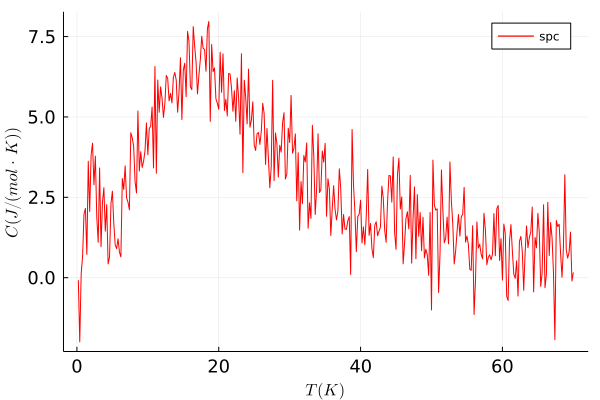

In [27]:
#spc
plot(Temp_table_spc,  SpcHeat_Temp_noise ,label="spc",color="red")
plot!(xlabel=L"T(K)",ylabel=L"C(J/(mol \cdot K))")
plot!(legendfontsize=10,xtickfont=font(12), ytickfont=font(12))
plot!(legend=:topright)

In [28]:
savefig(path * "data_spc.pdf")

# hyper parameter int

In [29]:
function para_int()
    L = 80
    gamma = 1.3
    return L, gamma
end
L_int, gamma_int = para_int()

(80, 1.3)

In [30]:
#int_parameter_B40
function para_int_B40()
    C = 0.001 #stepsize
    d = 1.3
    return C, d
end
C_int_B40, d_int_B40 = para_int_B40()

(0.001, 1.3)

In [31]:
df_int_para = DataFrame(
    name = ["L","gamma","C","d"],
    B40 = [L_int, gamma_int, C_int_B40, d_int_B40],
)

,name,B40
,String,Float64
1,L,80.0
2,gamma,1.3
3,C,0.001
4,d,1.3


In [32]:
df_int_para |> CSV.write(path * "int_para.csv",delim=",",writeheader=true)

"/Users/nishimurarei/home/lab/data/cubic_data/int/001_1/int_para.csv"

# 逆温度リスト

In [33]:
function beta_list_int()
    beta_int = zeros(L_int)
    
    for i in 2:L_int
        beta_int[i] = gamma_int^(i - L_int)
    end
    
    return beta_int
end
beta_int = beta_list_int()

80-element Vector{Float64}:
 0.0
 1.295443630733517e-9
 1.6840767199535721e-9
 2.1892997359396437e-9
 2.846089656721537e-9
 3.699916553737998e-9
 4.809891519859398e-9
 6.252858975817217e-9
 8.128716668562382e-9
 1.0567331669131098e-8
 1.3737531169870427e-8
 1.7858790520831557e-8
 2.3216427677081025e-8
 ⋮
 0.055798577143389
 0.0725381502864057
 0.0942995953723274
 0.12258947398402563
 0.15936631617923333
 0.20717621103300332
 0.2693290743429043
 0.35012779664577565
 0.45516613563950836
 0.5917159763313609
 0.7692307692307692
 1.0

In [34]:
function step_list_int()
    step_int_B40 = ones(L_int) * C_int_B40
    
    for i in 1:L_int
        if n_int * beta_int[i]  > 1
            step_int_B40[i] = C_int_B40 / (n_int * beta_int[i])^d_int_B40
        end
    end
    
    return step_int_B40
    
end

step_int_B40 = step_list_int()

80-element Vector{Float64}:
 0.001
 0.001
 0.001
 0.001
 0.001
 0.001
 0.001
 0.001
 0.001
 0.001
 0.001
 0.001
 0.001
 ⋮
 8.52633684306137e-6
 6.062281906937375e-6
 4.3103225447969476e-6
 3.064667847089738e-6
 2.178999115581987e-6
 1.5492827877630857e-6
 1.101550312386368e-6
 7.832095601284501e-7
 5.568671790830055e-7
 3.959362486446234e-7
 2.8151329235981035e-7
 2.001578134019032e-7

In [35]:
df_int_step = DataFrame(
    B40 = step_int_B40,
)

,B40
,Float64
1,0.001
2,0.001
3,0.001
4,0.001
5,0.001
6,0.001
7,0.001
8,0.001
9,0.001


In [36]:
df_int_step |> CSV.write(path * "int_step.csv",delim=",",writeheader=true)

"/Users/nishimurarei/home/lab/data/cubic_data/int/001_1/int_step.csv"

# 誤差関数

In [37]:
function error_chi(B40)
    error_value = sum((chi_inv_Temp_noise - chi(Onn_make(B40))).^2)/(2*n_chi)
    return error_value
end

error_chi (generic function with 1 method)

In [38]:
function error_spc(B40)
    error_value = sum((SpcHeat_Temp_noise - spc(Onn_make(B40))).^2)/(2*n_spc)
    return error_value
end

error_spc (generic function with 1 method)

In [39]:
function error_int(B40)
    error_value = (n_chi/n_int) * (b_chi/b_int) * error_chi(B40) + (n_spc/n_int) * (b_spc/b_int) * error_spc(B40)
    return error_value
end

error_int (generic function with 1 method)

In [40]:
#test
println("error chi:", error_chi(B40_true))
println("error spc:", error_spc(B40_true))
println("error int:", error_int(B40_true))

error chi:5.21281694429901e-5
error spc:0.43800917946945583
error int:4.7959747720195824e-5


In [41]:
function error_list_int(B40_list)
    error_ls = zeros(L_int)
    @threads for i in 1:L_int
        error_ls[i] = error_int(B40_list[i])
    end
    return error_ls
end

error_list_int (generic function with 1 method)

# 誤差関数最小パラメータ確認

In [42]:
#B40_sample = collect(-100:0.001:100)

In [43]:
#=
error_sample_list = zeros(length(B40_sample))
@threads for i in 1:length(B40_sample)
    error_sample_list[i] = error_int(B40_sample[i])
end
=#

In [44]:
#=
plot(B40_sample,error_sample_list,legend=:false)
plot!(xlabel=L"B40",ylabel="error")
=#

In [45]:
#savefig(path * "int_error_B40.pdf")

In [46]:
B40_sample = collect(0:0.0001:1)

10001-element Vector{Float64}:
 0.0
 0.0001
 0.0002
 0.0003
 0.0004
 0.0005
 0.0006
 0.0007
 0.0008
 0.0009
 0.001
 0.0011
 0.0012
 ⋮
 0.9989
 0.999
 0.9991
 0.9992
 0.9993
 0.9994
 0.9995
 0.9996
 0.9997
 0.9998
 0.9999
 1.0

In [47]:
error_sample_list = zeros(length(B40_sample))
@threads for i in 1:length(B40_sample)
    error_sample_list[i] = error_int(B40_sample[i])
end

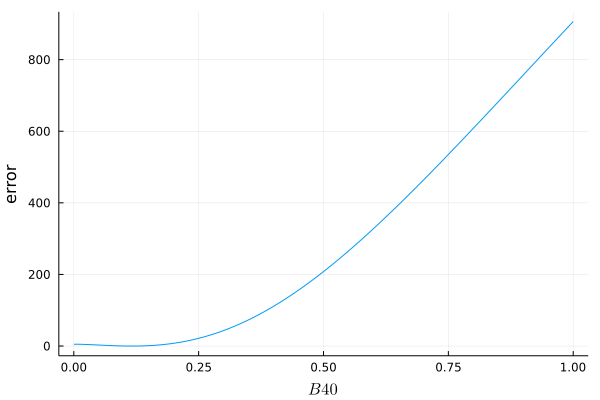

In [48]:
plot(B40_sample,error_sample_list,legend=:false)
plot!(xlabel=L"B40",ylabel="error")

In [49]:
savefig(path * "int_error_B40_focus.pdf")

In [50]:
para_min = B40_sample[argmin(error_sample_list)]
para_dif = abs(para_min - B40_true)
println("para_min:",para_min)
println("true_para:",B40_true)
println("dif:", para_dif)

para_min:0.1167
true_para:0.1167
dif:0.0


# 事前分布

In [51]:
function cauchy(x,x0,gamma)
    f = (1/pi) * (gamma/((x-x0)^2+gamma^2))
    return f
end

cauchy (generic function with 1 method)

In [52]:
function prior(B40)
    prior_B40 = cauchy(B40,0,5)
    return prior_B40
end

prior (generic function with 1 method)

In [53]:
function prior_list(B40_list)
    prior_list = zeros(L_int)
    for i in 1:L_int
        prior_list[i] = prior(B40_list[i])
    end
    return prior_list
end

prior_list (generic function with 1 method)

# EXMC

In [54]:
# metropolis
function metropolis_int(B40_list, saitaku)
    
    B40_proposed = B40_list + rand([-1,1],L_int) .* step_int_B40
    
    #事前分布
    prior_ratio = prior_list(B40_proposed) ./ prior_list(B40_list)
    
    err_proposed = error_list_int(B40_proposed)
    err_ini = error_list_int(B40_list)
    
    error_dif = err_proposed - err_ini
    
    bit_vec = rand(L_int) .< exp.(- n_int * b_int * beta_int .* error_dif) .* prior_ratio
    
    for i in 1:L_int
        if bit_vec[i] == 0 # 交換しない
            B40_proposed[i] = B40_list[i]
        else #交換
            saitaku[i] += 1
        end
    end
    
    return B40_proposed, saitaku, err_ini
end

metropolis_int (generic function with 1 method)

In [55]:
function exchange_int(B40_list, koukann, koukann_total)

    @threads for _ in 1:L_int-1
        #レプリカからランダムに選択
        l = rand(collect(1:L_int-1))
        
        beta_dif = beta_int[l + 1] - beta_int[l]
        error_dif = error_int(B40_list[l + 1]) - error_int(B40_list[l])
        v = exp(n_int * b_int * beta_dif * error_dif)
        u = minimum([1,v])
        items = [1,0]
        weights = [u,1 - u]
        item = sample(items, Weights(weights)) # 1で交換
        
        #交換
        if item == 1
            B40_list[l + 1], B40_list[l] = B40_list[l], B40_list[l + 1]
            koukann[l] += 1
        else
            koukann[l] += 0
        end

        #レプリカ選択の記録
        koukann_total[l] += 1
    end

    return　B40_list, koukann, koukann_total
end

exchange_int (generic function with 1 method)

In [56]:
# exmc
function emc_int(size_simu, frequency_exchange)
    # 初期パラメータ値
    
    #真値付近からスタート(for_check)
    B40_start = B40_true + rand()
    B40_list = B40_start * ones(L_int)
    
    #格納用(beta=1の値を保存)
    B40_keep = zeros(size_simu,L_int)
    
    #採択率,交換率記録
    saitaku = zeros(L_int)
    koukann = zeros(L_int)
    koukann_total = zeros(L_int)
    
    #各温度誤差関数の値記録
    error_func_list = zeros(size_simu,L_int)
    
    # 更新
    r = Progress(size_simu; showspeed=true)

    
    for iter in 1:size_simu
        B40_list, saitaku, error_ini = metropolis_int(B40_list, saitaku)
        error_func_list[iter, :] = error_ini
        
        if iter % frequency_exchange == 0
           B40_list, koukann, koukann_total = exchange_int(B40_list, koukann, koukann_total)
        end
        
        B40_keep[iter,:] = B40_list
        
        ProgressMeter.next!(r)
    end
    
    saitaku = saitaku / size_simu
    
    koukann = koukann ./ koukann_total
    
    return B40_keep, saitaku, koukann, error_func_list
end

emc_int (generic function with 1 method)

In [59]:
mc_step = 5000
exchange_frequency = 3

3

In [60]:
B40_list_int, saitaku_int, koukann_int, error_func_list_int = emc_int(mc_step, exchange_frequency)

Progress: 100%|███████████████████████████| Time: 0:22:54 ( 0.27  s/it)


([0.8850783391927527 0.8830783391927527 … 0.8840780576794603 0.8840783391927527; 0.8840783391927527 0.8840783391927527 … 0.8840780576794603 0.8840783391927527; … ; 0.8030783391927526 0.8520783391927527 … 0.1166937636842466 0.11667859702867413; 0.8040783391927526 0.8510783391927527 … 0.11669404519753895 0.11667839687086072], [0.9998, 0.9938, 0.9912, 0.9878, 0.9862, 0.9814, 0.9756, 0.9706, 0.9572, 0.9486  …  0.7134, 0.7224, 0.7278, 0.7172, 0.732, 0.742, 0.7476, 0.7444, 0.755, 0.747], [0.7971614429331756, 0.9237804878048781, 0.9084057971014493, 0.8637189582071472, 0.8166666666666667, 0.7612748045700541, 0.7036599763872491, 0.6660818713450293, 0.6987951807228916, 0.6747211895910781  …  0.6123893805309735, 0.5987915407854985, 0.6115751789976134, 0.5851259987707437, 0.5846895720313442, 0.5523290986085905, 0.5727056019070322, 0.5640117994100295, 0.49501246882793015, NaN], [733.3704013640623 733.3704013640623 … 733.3704013640623 733.3704013640623; 734.8651823393839 731.8757010018442 … 733.3699

# 温度、採択率、交換率

In [61]:
df_vin_int = DataFrame(
    beta_temp = beta_int,
    
    B40 = step_int_B40,
    採択率_B40 = saitaku_int,
    
    交換率 = koukann_int
)

,beta_temp,B40,採択率_B40,交換率
,Float64,Float64,Float64,Float64
1,0.0,0.001,0.9998,0.797161
2,1.29544e-9,0.001,0.9938,0.92378
3,1.68408e-9,0.001,0.9912,0.908406
4,2.1893e-9,0.001,0.9878,0.863719
5,2.84609e-9,0.001,0.9862,0.816667
6,3.69992e-9,0.001,0.9814,0.761275
7,4.80989e-9,0.001,0.9756,0.70366
8,6.25286e-9,0.001,0.9706,0.666082
9,8.12872e-9,0.001,0.9572,0.698795


In [62]:
df_vin_int |> CSV.write(path * "vin_int.csv",delim=",",writeheader=true)

"/Users/nishimurarei/home/lab/data/cubic_data/int/001_1/vin_int.csv"

In [63]:
latexify(df_vin_int; env=:table, latex=false)

L"\begin{tabular}{cccc}
beta_temp & B40 & 採択率_B40 & 交換率\\
0.0 & 0.001 & 0.9998 & 0.7971614429331756\\
1.295443630733517e-9 & 0.001 & 0.9938 & 0.9237804878048781\\
1.6840767199535721e-9 & 0.001 & 0.9912 & 0.9084057971014493\\
2.1892997359396437e-9 & 0.001 & 0.9878 & 0.8637189582071472\\
2.846089656721537e-9 & 0.001 & 0.9862 & 0.8166666666666667\\
3.699916553737998e-9 & 0.001 & 0.9814 & 0.7612748045700541\\
4.809891519859398e-9 & 0.001 & 0.9756 & 0.7036599763872491\\
6.252858975817217e-9 & 0.001 & 0.9706 & 0.6660818713450293\\
8.128716668562382e-9 & 0.001 & 0.9572 & 0.6987951807228916\\
1.0567331669131098e-8 & 0.001 & 0.9486 & 0.6747211895910781\\
1.3737531169870427e-8 & 0.001 & 0.9382 & 0.16666666666666666\\
1.7858790520831557e-8 & 0.001 & 0.9286 & 0.5699940933254578\\
2.3216427677081025e-8 & 0.001 & 0.8982 & 0.3505275498241501\\
3.0181355980205335e-8 & 0.001 & 0.8846 & 0.19880239520958085\\
3.923576277426693e-8 & 0.001 & 0.8828 & 0.12378048780487805\\
5.100649160654702e-8 & 0.001 & 0.8

# 保存

In [64]:
df_B40_int = DataFrame(
    B40_list_int, :auto
)

df_B40_int |> CSV.write(path * "para_B40_int.csv",delim=",",writeheader=true)

"/Users/nishimurarei/home/lab/data/cubic_data/int/001_1/para_B40_int.csv"

In [65]:
df_error_int = DataFrame(
    error_func_list_int, :auto
)
df_error_int |> CSV.write(path * "error_int.csv",delim=",",writeheader=true)

"/Users/nishimurarei/home/lab/data/cubic_data/int/001_1/error_int.csv"

# 自由エネルギー

In [66]:
#check_free_energy
function find_free_energy_int(error_func_list,burn_in)
    #バーンイン後のエネルギー関数抽出
    error_func_check = error_func_list[burn_in+1:end,1:end-1]
    
    #温度差
    beta_dif = beta_int[2:end] - beta_int[1:end-1]
    
    #温度差をかける
    for replica in 1:L_int-1
        error_func_check[:,replica] *= beta_dif[replica]
    end
    
    #n,noiseをかける
    error_func_check *= - n_int* b_int
    
    #最大値取得
    error_func_check_max = zeros(L_int-1)
    for replica in 1:L_int-1
        error_func_check_max[replica] = maximum(error_func_check[:,replica])
    end
    
    #最大値で引いたエネルギー関数
    error_func_check_dif = copy(error_func_check)
    for replica in 1:L_int-1
        error_func_check_dif[:,replica] = error_func_check[:,replica] .- error_func_check_max[replica]
    end
    
    #expの肩にのせる
    error_func_check_dif = exp.(error_func_check_dif)
    
    #各レプリカごとで先程の最大値を引いた差の和をとる
    sum_for_replica = zeros(L_int-1)
    for replica in 1:L_int-1
        sum_for_replica[replica] = sum(error_func_check_dif[:,replica])
    end
    
    #各レプリカごとで計算
    for_replica = zeros(L_int-1)
    for replica in 1:L_int-1
        for_replica[replica] = error_func_check_max[replica] + log(sum_for_replica[replica]) - log(size(error_func_list)[1] - burn_in)
    end
    
    #自由エネルギー
    free_energy = - n_chi/2*(log(b_chi)-log(2*pi)) - n_spc/2*(log(b_spc)-log(2*pi)) -sum(for_replica)
    
    return free_energy
end

find_free_energy_int (generic function with 1 method)

In [75]:
mc_step

5000

In [76]:
free_energy_int = find_free_energy_int(error_func_list_int, 4900)
free_energy_int

-556.5600721367873

In [68]:
df_free_energy = DataFrame(自由エネルギー = free_energy_int)
df_free_energy |> CSV.write(path * "free_energy.csv",delim=",",writeheader=true)

"/Users/nishimurarei/home/lab/data/cubic_data/int/001_1/free_energy.csv"

# 自由エネルギー変化

In [69]:
list_end = Vector(100:100:mc_step)

50-element Vector{Int64}:
  100
  200
  300
  400
  500
  600
  700
  800
  900
 1000
 1100
 1200
 1300
    ⋮
 3900
 4000
 4100
 4200
 4300
 4400
 4500
 4600
 4700
 4800
 4900
 5000

In [70]:
list_start = Vector(1:100:mc_step)
list_start = list_start[1:length(list_end)]

50-element Vector{Int64}:
    1
  101
  201
  301
  401
  501
  601
  701
  801
  901
 1001
 1101
 1201
    ⋮
 3801
 3901
 4001
 4101
 4201
 4301
 4401
 4501
 4601
 4701
 4801
 4901

In [71]:
free_energy_list = zeros(length(list_start))
for i in 1:length(list_start)
    free_energy_list[i] = find_free_energy_int(error_func_list_int[list_start[i]:list_end[i],:],0)
end

In [72]:
free_energy_list

50-element Vector{Float64}:
    5.009136828126652e9
    4.489531536520038e9
    4.017684278636841e9
    3.4997805805154624e9
    3.089511590485704e9
    2.794245094348238e9
    2.5643294641901255e9
    2.503669869247774e9
    2.3706965946530704e9
    2.0147025318975894e9
    1.5951391707526903e9
    1.2898426418849735e9
    1.0077930199312943e9
    ⋮
 -523.6290461730259
 -527.3841223829587
 -531.2916854530043
 -530.086684989783
 -534.0216445525807
 -539.2666295267891
 -538.0605621774451
 -543.6109640901209
 -547.2773123995637
 -551.1847609321278
 -552.6693225202351
 -556.5600721367873

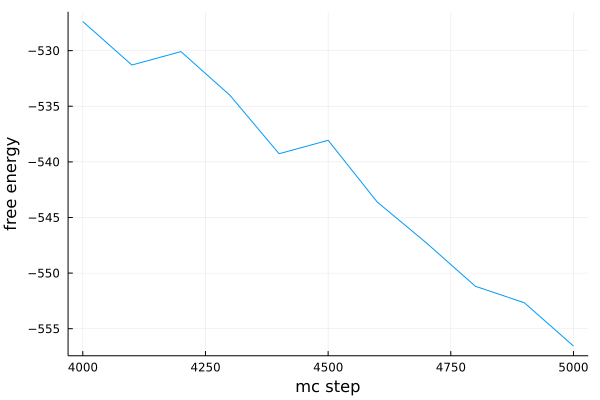

In [74]:
start_num = 40
plot(list_end[start_num:end],free_energy_list[start_num:end])
plot!(xlabel="mc step",ylabel="free energy")
plot!(legend=false)

In [77]:
savefig(path * "free_energy_change.pdf")

# 事後分布

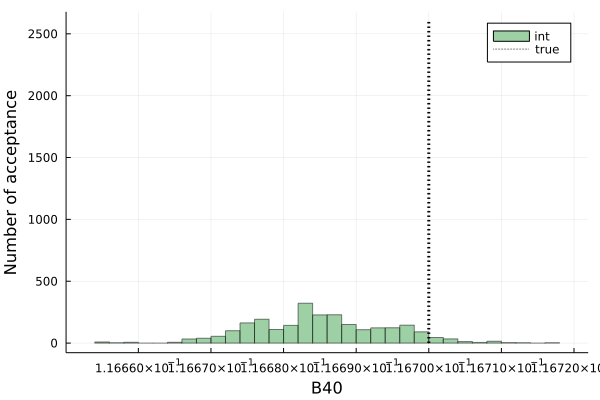

In [78]:
burn_in = Int(mc_step/2)
true_height = 2600

p1 = plot(B40_list_int[burn_in:end,end],st=:histogram,label="int",alpha=0.5,color=palette(:default)[3]) #yaxis=:logでlog
p1 = plot!(xlabel="B40",ylabel="Number of acceptance")
p1 = plot!(B40_true*ones(true_height),collect(1:true_height), linestyle=:dot,linewidth = 3,label="true",color=:black)


In [79]:
savefig(path * "int_hist.pdf")

# 平均、分散

In [80]:
burn_in = 4800

4800

In [81]:
int_mean = mean(B40_list_int[burn_in:end,end])
int_mean

0.11668083239099598

In [82]:
std(B40_list_int[80000:end,end])

NaN

In [83]:
burn_in

4800

In [84]:
int_std = std(B40_list_int[burn_in:end,end])
int_std

9.704006152224477e-6

In [85]:
df_mean_std = DataFrame(
    mean = int_mean,
    std = int_std
)

,mean,std
,Float64,Float64
1,0.116681,9.70401e-6


In [86]:
df_mean_std |> CSV.write(path * "mean_std_int.csv",delim=",",writeheader=true)

"/Users/nishimurarei/home/lab/data/cubic_data/int/001_1/mean_std_int.csv"

# 事後分布全部

In [132]:
read_path

"/Users/nishimurarei/home/lab/data/cubic_data/check/"

In [133]:
df_B40_chi = CSV.read(read_path * "chi/para_B40_chi.csv", DataFrame)
B40_list_chi = Matrix(df_B40_chi[:, :]);

In [134]:
df_B40_spc = CSV.read(read_path * "spc/para_B40_spc.csv", DataFrame)
B40_list_spc = Matrix(df_B40_spc[:, :]);

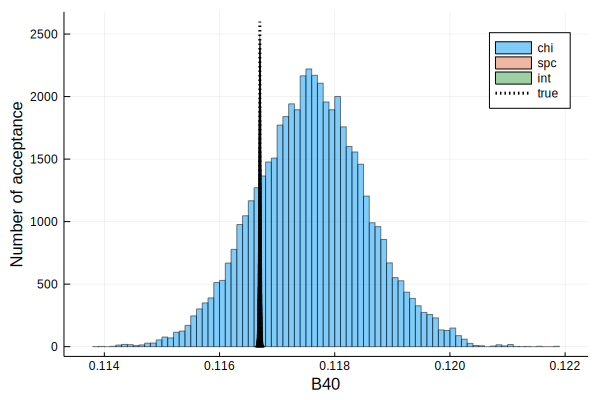

In [163]:
burn_in = Int(mc_step/2)
true_height = 2600

#chi
plot(B40_list_chi[burn_in:end,end],st=:histogram,label="chi",alpha=0.5,color=palette(:default)[1]) #yaxis=:logでlog

#spc
plot!(B40_list_spc[burn_in:end,end],st=:histogram,label="spc",alpha=0.5,color=palette(:default)[2]) #yaxis=:logでlog

#int
plot!(B40_list_int[burn_in:end,end],st=:histogram,label="int",alpha=0.5,color=palette(:default)[3]) #yaxis=:logでlog

plot!(xlabel="B40",ylabel="Number of acceptance")
plot!(B40_true*ones(true_height),collect(1:true_height), linestyle=:dot,linewidth = 3,label="true",color=:black)

In [164]:
savefig(path * "all_hist.pdf")

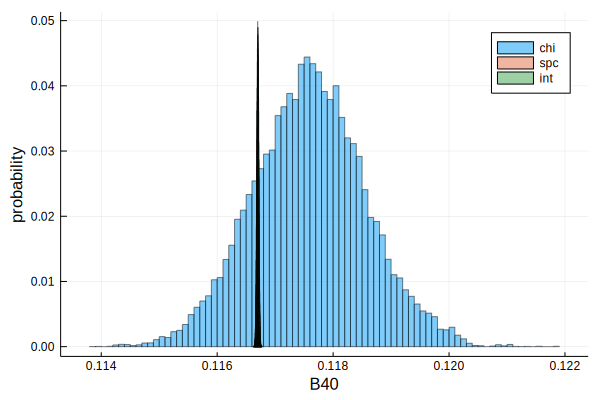

In [230]:
burn_in = Int(mc_step/2)
true_height = 0.05

#chi
plot(B40_list_chi[burn_in:end,end],st=:histogram,label="chi",alpha=0.5,color=palette(:default)[1],normalize=:probability) #yaxis=:logでlog

#spc
plot!(B40_list_spc[burn_in:end,end],st=:histogram,label="spc",alpha=0.5,color=palette(:default)[2],normalize=:probability) #yaxis=:logでlog

#int
plot!(B40_list_int[burn_in:end,end],st=:histogram,label="int",alpha=0.5,color=palette(:default)[3],normalize=:probability) #yaxis=:logでlog

plot!(xlabel="B40",ylabel="probability")
#plot!(B40_true*ones(true_height),collect(1:true_height), linestyle=:dot,linewidth = 3,label="true",color=:black,normalize=:probability)
#plot!(xlim=[0.1166,0.1168])


In [232]:
savefig("/Users/nishimurarei/home/lab/data/cubic_data/int/1_001/all_hist_normalize.pdf")

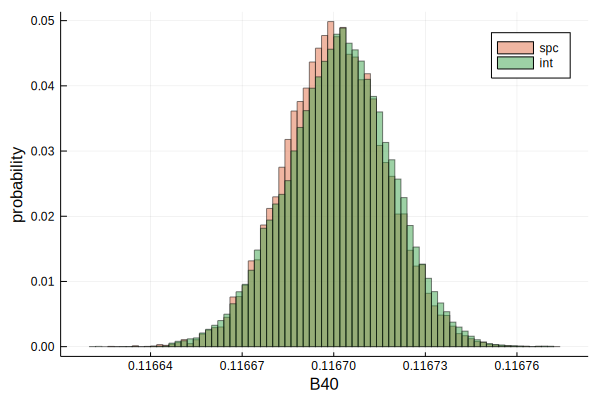

In [227]:
burn_in = Int(mc_step/2)
true_height = 0.05

#chi
#plot(B40_list_chi[burn_in:end,end],st=:histogram,label="chi",alpha=0.5,color=palette(:default)[1],normalize=:probability) #yaxis=:logでlog

#spc
plot(B40_list_spc[burn_in:end,end],st=:histogram,label="spc",alpha=0.5,color=palette(:default)[2],normalize=:probability) #yaxis=:logでlog

#int
plot!(B40_list_int[burn_in:end,end],st=:histogram,label="int",alpha=0.5,color=palette(:default)[3],normalize=:probability) #yaxis=:logでlog

plot!(xlabel="B40",ylabel="probability")
#plot!(B40_true*ones(true_height),collect(1:true_height), linestyle=:dot,linewidth = 3,label="true",color=:black,normalize=:probability)
#plot!(xlim=[0.1166,0.1168])


In [229]:
savefig("/Users/nishimurarei/home/lab/data/cubic_data/int/1_001/all_hist_normalize_focus.pdf")

## bin 調整方法

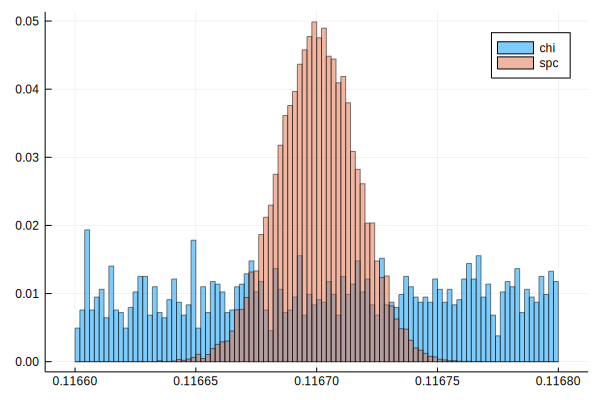

In [201]:
burn_in = Int(mc_step/2)
true_height = 2600

#chi
plot(B40_list_chi[burn_in:end,end],st=:histogram,label="chi",alpha=0.5,color=palette(:default)[1],normalize=:probability, bins = range(0.1166,0.1168, step = 0.000002)) #yaxis=:logでlog


#spc
plot!(B40_list_spc[burn_in:end,end],st=:histogram,label="spc",alpha=0.5,color=palette(:default)[2],normalize=:probability, bins = range(0.1166,0.1168, step = 0.000002)) #yaxis=:logでlog
#=
#int
plot!(B40_list_int[burn_in:end,end],st=:histogram,label="int",alpha=0.5,color=palette(:default)[3],normalize=:probability, bins = range(0.114,0.122, step = 0.01)) #yaxis=:logでlog

plot!(xlabel="B40",ylabel="Number of acceptance")
#plot!(B40_true*ones(true_height),collect(1:true_height), linestyle=:dot,linewidth = 3,label="true",color=:black)
#plot!(xlim=[0.1166,0.1168])
=#

# 自由エネルギー比較

In [208]:
df_chi_free_energy = CSV.read(read_path * "chi/free_energy.csv", DataFrame)
free_energy_chi = df_chi_free_energy.自由エネルギー

1-element Vector{Float64}:
 510.0813112481385

In [209]:
df_spc_free_energy = CSV.read(read_path * "spc/free_energy.csv", DataFrame)
free_energy_spc = df_spc_free_energy.自由エネルギー

1-element Vector{Float64}:
 -1014.6464762949074

In [210]:
free_energy_int

-477.8771675261333

In [215]:
df_free_energy_all = DataFrame(
    chi = free_energy_chi,
    spc = free_energy_spc,
    int = free_energy_int,
    chispc = free_energy_chi + free_energy_spc
)

,chi,spc,int,chispc
,Float64,Float64,Float64,Float64
1,510.081,-1014.65,-477.877,-504.565


# 平均、分散比較

In [223]:
df_chi_mean_std = CSV.read(read_path * "chi/mean_std_chi.csv", DataFrame)
chi_mean = df_chi_mean_std.mean[]
chi_std = df_chi_mean_std.std[];

In [224]:
df_spc_mean_std = CSV.read(read_path * "spc/mean_std_spc.csv", DataFrame)
spc_mean = df_spc_mean_std.mean[]
spc_std = df_spc_mean_std.std[];

In [226]:
df_free_energy_all = DataFrame(
    index = ["chi","spc","int"],
    mean = [chi_mean, spc_mean, int_mean],
    std = [chi_std, spc_std, int_std],
)

,index,mean,std
,String,Float64,Float64
1,chi,0.117591,0.000969852
2,spc,0.1167,1.65581e-5
3,int,0.116702,1.7201e-5
